In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import xml.etree.ElementTree as ET


In [296]:
vdj_train_path = "vdj_seqs_tsp7.fasta"
vdj_test_path = "vdj_seqs_tsp10.fasta"
non_vdj_train_path = "non_vdj_seqs_tsp7.fasta"
non_vdj_test_path = "non_vdj_seqs_tsp10.fasta"

In [297]:
def read_fasta(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
        sequences = []
        for line in lines:
            if line[0] != ">":
                sequences.append(line.strip())
    return sequences

In [298]:
#onehot encode the sequences efficiently
def onehot_encode(sequences):
    onehot = np.zeros((len(sequences), len(sequences[0]), 4))
    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base == "A":
                onehot[i, j, 0] = 1
            elif base == "C":
                onehot[i, j, 1] = 1
            elif base == "G":
                onehot[i, j, 2] = 1
            elif base == "T":
                onehot[i, j, 3] = 1
    return onehot

In [299]:
# function to calculate score by scanning motif through sequence
def scan_motif(sequence, motif):
    score = np.zeros(len(sequence) - len(motif) + 1)
    for i in range(len(sequence) - len(motif) + 1):
        score[i] = np.sum(sequence[i:i+len(motif)] * motif)
    return score 

In [300]:
# wrap the above to function
def scan_motifs(sequences, motifs):
    scores = []
    for i in range(len(motifs)):
        score = np.zeros((len(sequences), len(sequences[0]) - len(motifs[i]) + 1))
        for j in range(len(sequences)):
            score[j] = scan_motif(sequences[j], motifs[i])
        scores.append(score)
    return scores        

In [301]:


def parse_motifs_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    motifs = []
    
    for motif in root.findall('.//motif'):
        motif_id = motif.get('id')
        width = int(motif.get('width'))
        
        pwm = np.zeros((width, 4))
        pos_list = motif.findall('.//pos')
        
        for i, pos in enumerate(pos_list):
            pwm[i][0] = float(pos.get('A'))
            pwm[i][1] = float(pos.get('C'))
            pwm[i][2] = float(pos.get('G'))
            pwm[i][3] = float(pos.get('T'))
        
        motifs.append({'motif_id': motif_id, 'pwm': pwm})
    
    return motifs

In [302]:
#read all motif csv files
rgadem_motifs = []
for i in range(1, 11):
    motif = pd.read_csv(f"motif_{i}.csv")
    motif = motif.drop("Unnamed: 0", axis = 1).to_numpy()
    rgadem_motifs.append(motif.T)
motif_length = [len(motif) for motif in rgadem_motifs]

In [303]:
xml_file = 'streme_vdj.xml'  # Replace 'your_file.xml' with the path to your XML file
streme_motifs = parse_motifs_from_xml(xml_file)
streme_motifs = [motif['pwm'] for motif in streme_motifs]


In [215]:
# motifs = motifs[:3] + streme_motifs[:3] 
# motifs = motifs

In [304]:
train_seqs = read_fasta(vdj_train_path) + read_fasta(non_vdj_train_path)
test_seqs = read_fasta(vdj_test_path) + read_fasta(non_vdj_test_path)
train_seqs = pd.DataFrame(train_seqs, columns=["sequence"])
test_seqs = pd.DataFrame(test_seqs, columns=["sequence"])
train_seqs["label"] = [1]*len(read_fasta(vdj_train_path)) + [0]*len(read_fasta(non_vdj_train_path))
test_seqs["label"] = [1]*len(read_fasta(vdj_test_path)) + [0]*len(read_fasta(non_vdj_test_path))
onehot_train = onehot_encode(train_seqs["sequence"])
onehot_test = onehot_encode(test_seqs["sequence"])


In [305]:
motifs = rgadem_motifs
scores_train = scan_motifs(onehot_train, motifs)
scores_test = scan_motifs(onehot_test, motifs)

# add columns to train dataframe for each motif
for i in range(len(scores_train)):
    train_seqs[f"motif_{i+1}"] = np.max(scores_train[i], axis = 1)
for i in range(len(scores_test)):
    test_seqs[f"motif_{i+1}"] = np.max(scores_test[i], axis = 1)

In [237]:
scores_train[0].shape

(670, 46)

In [306]:
# scale the motif scores
scaler = StandardScaler()
train_seqs.iloc[:, 2:] = scaler.fit_transform(train_seqs.iloc[:, 2:])
test_seqs.iloc[:, 2:] = scaler.transform(test_seqs.iloc[:, 2:])
# add column of avergae score and max score for each sequence
# train_seqs["avg_score"] = train_seqs.iloc[:, 2:].mean(axis = 1)
# train_seqs["max_score"] = train_seqs.iloc[:, 2:].max(axis = 1)
# test_seqs["avg_score"] = test_seqs.iloc[:, 2:].mean(axis = 1)
# test_seqs["max_score"] = test_seqs.iloc[:, 2:].max(axis = 1)
train_seqs.head()

,sequence,label,motif_1,motif_2,motif_3,motif_4,motif_5,motif_6,motif_7,motif_8,motif_9,motif_10
0,CAAGAACCAGGTCAGCCTGACCTGCCTGGTCAAAGGCTTCTATCCC...,1,3.503872,-0.584590,1.480646,-0.327152,-0.128850,1.348830,0.058148,-0.503744,-0.557214,0.051702
1,CTATAGCACAGCACTGACCGTGACCAGCGTCCGGGGCCCATCTGGC...,1,-0.330377,1.822195,0.180308,0.307749,0.920063,1.626380,1.917237,0.279936,0.018215,0.451845
2,CTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGGCCAACTCGTGG...,1,-0.329853,2.811341,-0.125825,-0.017100,-0.944458,0.295027,0.383393,-0.513478,0.568978,-0.730011
3,GGGCCTGAGCTCGCCCGTCACAAAGAGCTTCAACAGGGGAGAGTGT...,1,0.590734,-0.312555,2.644681,0.137709,-0.153015,0.043044,-1.024215,0.553367,-0.587973,-0.931168
4,CTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGG...,1,-0.244249,-0.605067,0.901422,-0.984638,0.898245,1.313478,-0.682580,0.715890,-0.045100,-0.873763


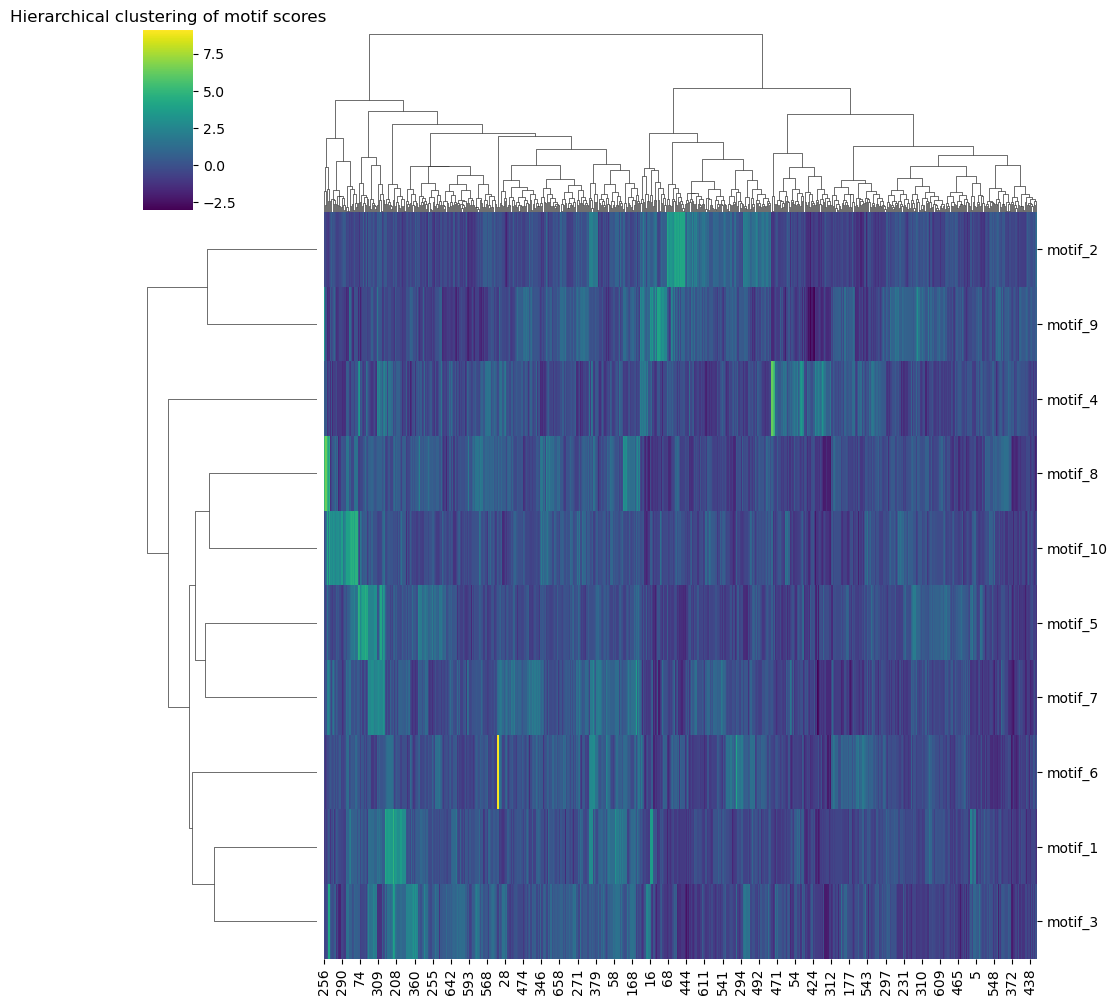

Number of clusters at distance 5: 77
Number of clusters at distance 6: 57
Number of clusters at distance 7: 43
Number of clusters at distance 8: 36
Number of clusters at distance 9: 32
Number of clusters at distance 10: 29
Number of clusters at distance 11: 19
Number of clusters at distance 12: 18
Number of clusters at distance 13: 16
Number of clusters at distance 14: 14
Number of clusters at distance 15: 12
Number of clusters at distance 16: 11
Number of clusters at distance 17: 10
Number of clusters at distance 18: 8
Number of clusters at distance 19: 7


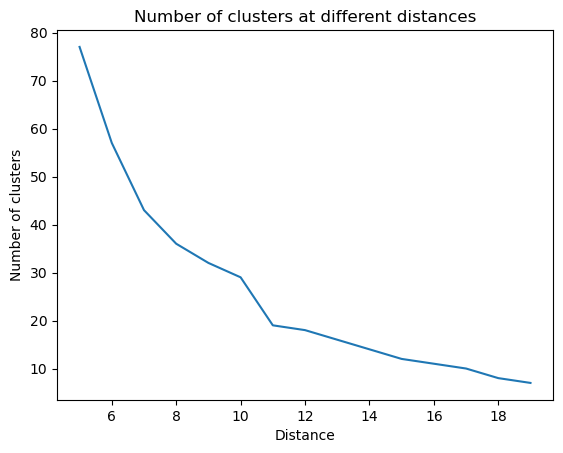

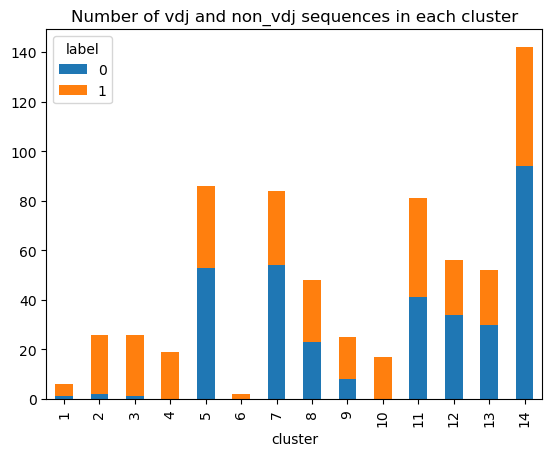

In [307]:
# subset train_seqs df to not include max_score and avg_score
if "cluster" in train_seqs.columns:
    train_seqs = train_seqs.drop("cluster", axis = 1)
X_train = train_seqs.iloc[:, 2:]
# perform hierarchical clustering on the train data
sns.clustermap(X_train.T, method = "ward", cmap = "viridis")
# add class label to the clustermap
y_train = train_seqs["label"]
y_train = y_train.map({0: "non_vdj", 1: "vdj"})
y_train = y_train.to_numpy()
plt.title("Hierarchical clustering of motif scores")
plt.show()
# cut the dendrogram at different levels to see how the clusters are formed
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
np.random.seed(0)
Z = linkage(X_train, method = "ward")
# dendrogram(Z, labels = X_train.T.columns)
# plt.title("Dendrogram of motif scores")
# plt.show()
# cut the dendrogram
clust_nums = []
for dist in range (5, 20):
    clusters = fcluster(Z, dist, criterion = "distance")
    clust_nums.append(len(np.unique(clusters)))
    print(f"Number of clusters at distance {dist}: {len(np.unique(clusters))}")

# plot the number of clusters at different distances
plt.plot(range(5, 20), clust_nums)
plt.xlabel("Distance")
plt.ylabel("Number of clusters")
plt.title("Number of clusters at different distances")
plt.show()

# get clusters at distance 11
clusters = fcluster(Z, 14, criterion = "distance")
train_seqs["cluster"] = clusters
X_train["cluster"] = clusters

# barplot of the number of vdj and non_vdj sequences in each cluster
cluster_counts = train_seqs.groupby(["cluster", "label"]).size().unstack()
cluster_counts.plot(kind = "bar", stacked = True)
plt.title("Number of vdj and non_vdj sequences in each cluster")
plt.show()





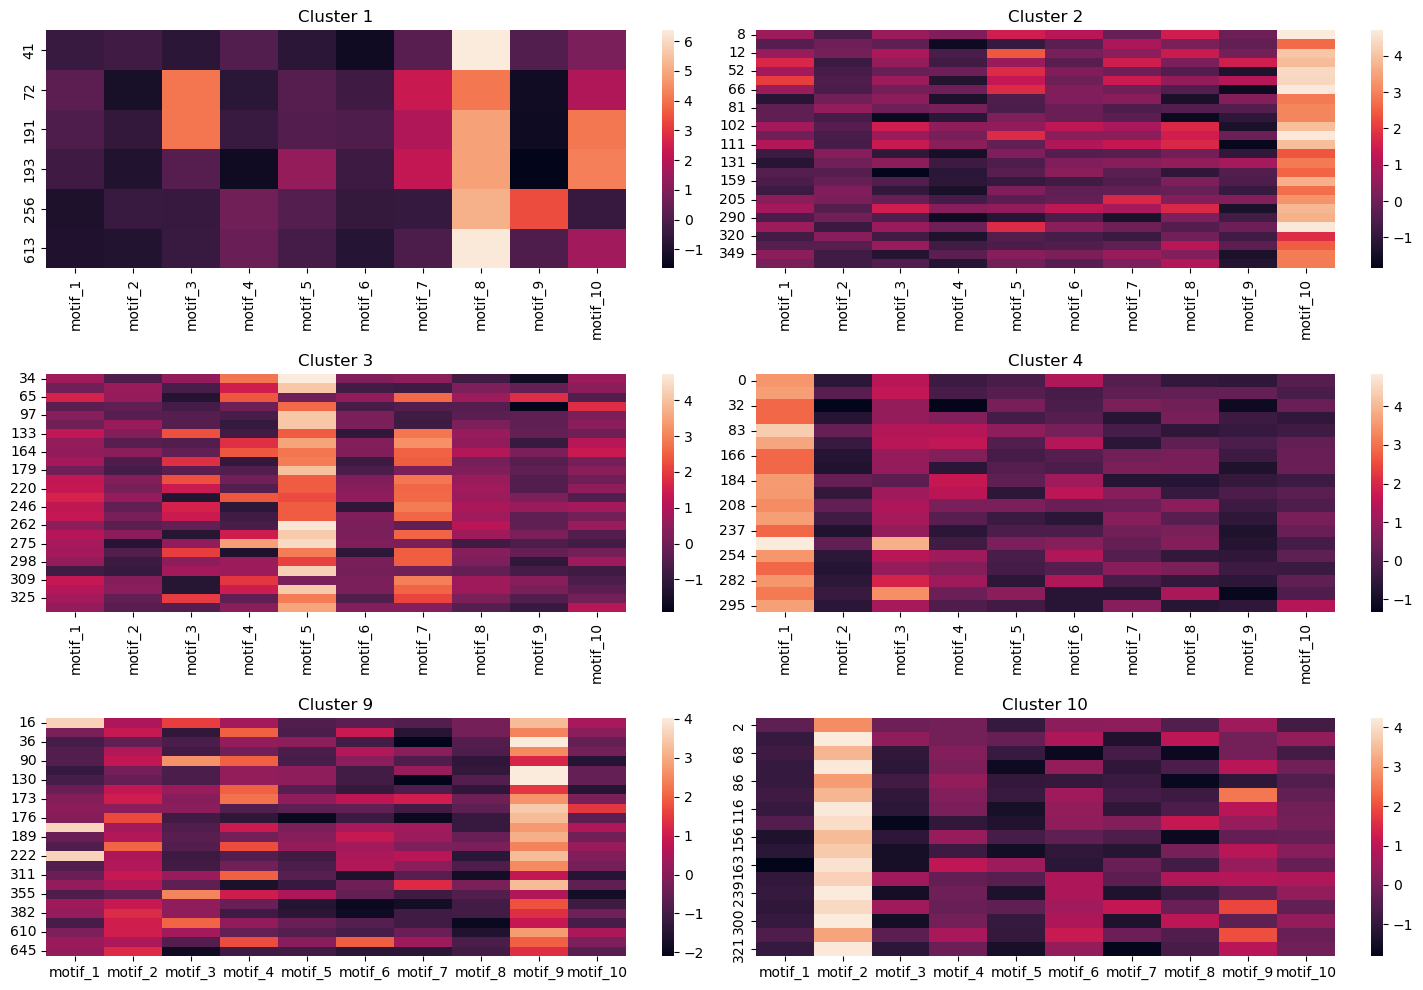

In [308]:
# subset cluster 1,2,5,6
selected_clusters = [1, 2, 3, 4, 9, 10]
cluster_subset = train_seqs[train_seqs["cluster"].isin(selected_clusters)]
#plot motif score for each cluster
fig, ax = plt.subplots(3, 2, figsize = (15, 10), tight_layout = True)
plt.title("Motif scores for each cluster")
for i, cluster in enumerate(selected_clusters):
    cluster_subset = train_seqs[train_seqs["cluster"] == cluster]
    cluster_subset = cluster_subset.iloc[:, 2:-1]
    sns.heatmap(cluster_subset, ax = ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"Cluster {cluster}")
plt.show()



In [309]:
selected_motif_index = [1,2,3,4,9,10]
# selected_motifs = [motifs[i] for i in selected_motif_index]

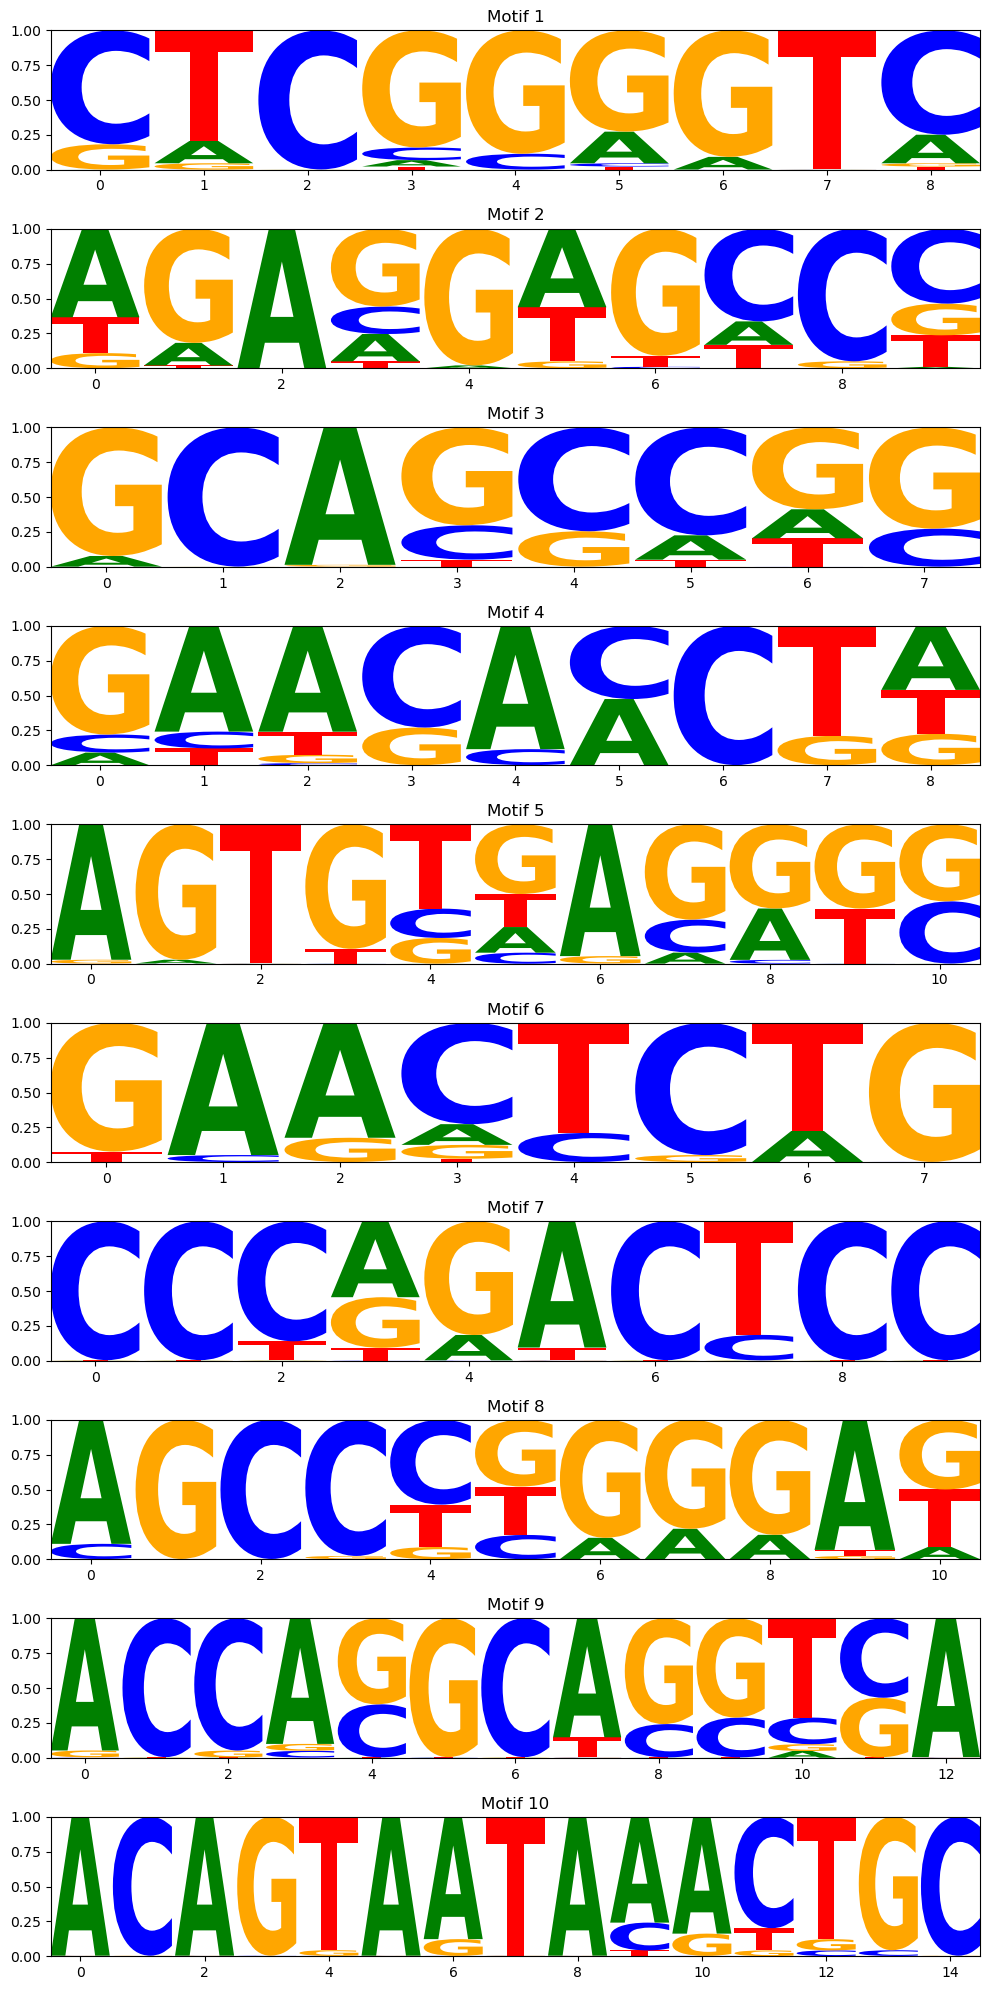

In [225]:
fig, ax = plt.subplots(10, 1, figsize = (10, 20), tight_layout = True)
for i, m in enumerate(motifs):
    ax[i].set_title(f"Motif {i + 1}")
    logomaker.Logo(pd.DataFrame(motifs[i], columns=["A", "C", "G", "T"]), ax = ax[i])

In [312]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


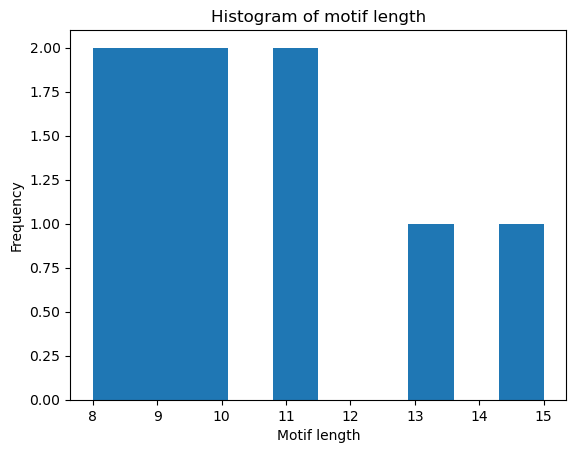

In [227]:
# histogram of motifs length
motif_length = [len(motif) for motif in motifs]
plt.hist(motif_length)
plt.xlabel("Motif length")
plt.ylabel("Frequency")
plt.title("Histogram of motif length")
plt.show()


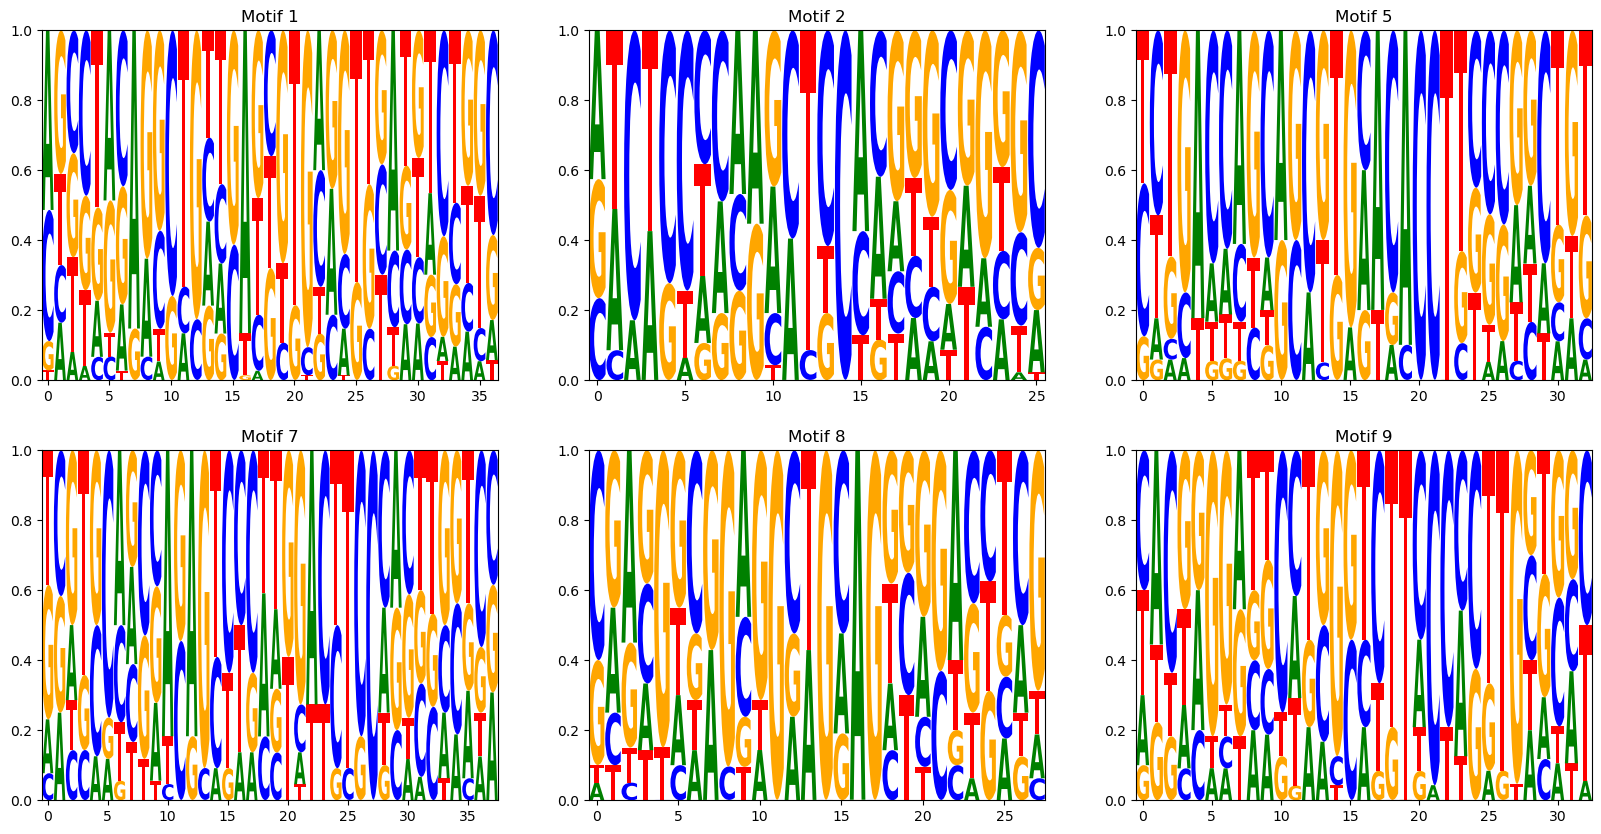

In [36]:
# logo plot of the motifs
import logomaker
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
for i, m in enumerate(selected_motif_index):
    ax[i//3, i%3].set_title(f"Motif {m}")
    logomaker.Logo(pd.DataFrame(motifs[m], columns=["A", "C", "G", "T"]), ax = ax[i//3, i%3])


In [62]:
from scipy.signal import convolve2d

# function to convolve 2 motifs and get the best score using np.convolve
def convolve_motifs(motif1, motif2):
    short_motif = motif1 if len(motif1) < len(motif2) else motif2
    long_motif = motif1 if len(motif1) > len(motif2) else motif2
    # long_motif = long_motif - np.mean(long_motif)
    # short_motif = short_motif - np.mean(short_motif)
    conv = convolve2d(long_motif, short_motif, mode = "valid")
    
    print(conv)
    return np.max(conv) / len(long_motif)

In [174]:
train_seqs.cluster.value_counts()

cluster
15    93
5     86
7     84
11    81
13    52
14    52
16    49
8     48
2     26
3     26
9     25
4     19
10    17
1      6
12     4
6      2
Name: count, dtype: int64

In [185]:
motif_index_cluster_map = {1: 4, 2: 10, 5: 3, 7: 3, 9: 9, 10: 2, 8:1}

In [195]:
selected_motif_index = list(motif_index_cluster_map.keys())
selected_motif_index[:-1]

[1, 2, 5, 7, 9, 10]

In [192]:
len(selected_motif_index)

7

In [234]:
len(motif_pos3)

10

ValueError: x and y must be the same size

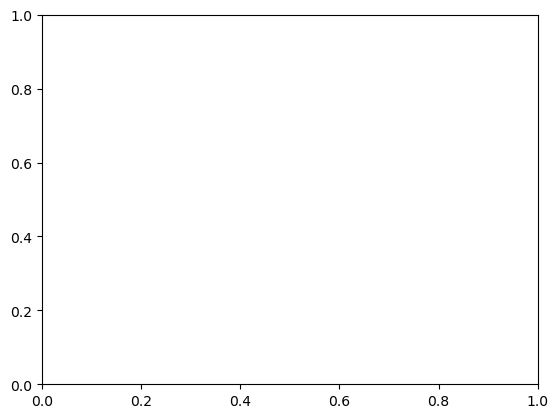

In [310]:
# motif_positions = []
# for motif_index in selected_motif_index:
cluster_seq_index = train_seqs[train_seqs["cluster"] == 9].index
motif_pos3 = scores_train[8].argmax(1)[cluster_seq_index]
cluster_seq_index = train_seqs[train_seqs["cluster"] == 10].index
motif_pos4 = scores_train[4].argmax(1)[cluster_seq_index]
# motif_positions.append(motif_pos)
# scatter plot
plt.scatter(motif_pos3, motif_pos4)
plt.xlabel("Motif 3 position")
plt.ylabel("Motif 4 position")
plt.title("Scatter plot of motif 3 and 4 positions")
plt.show()


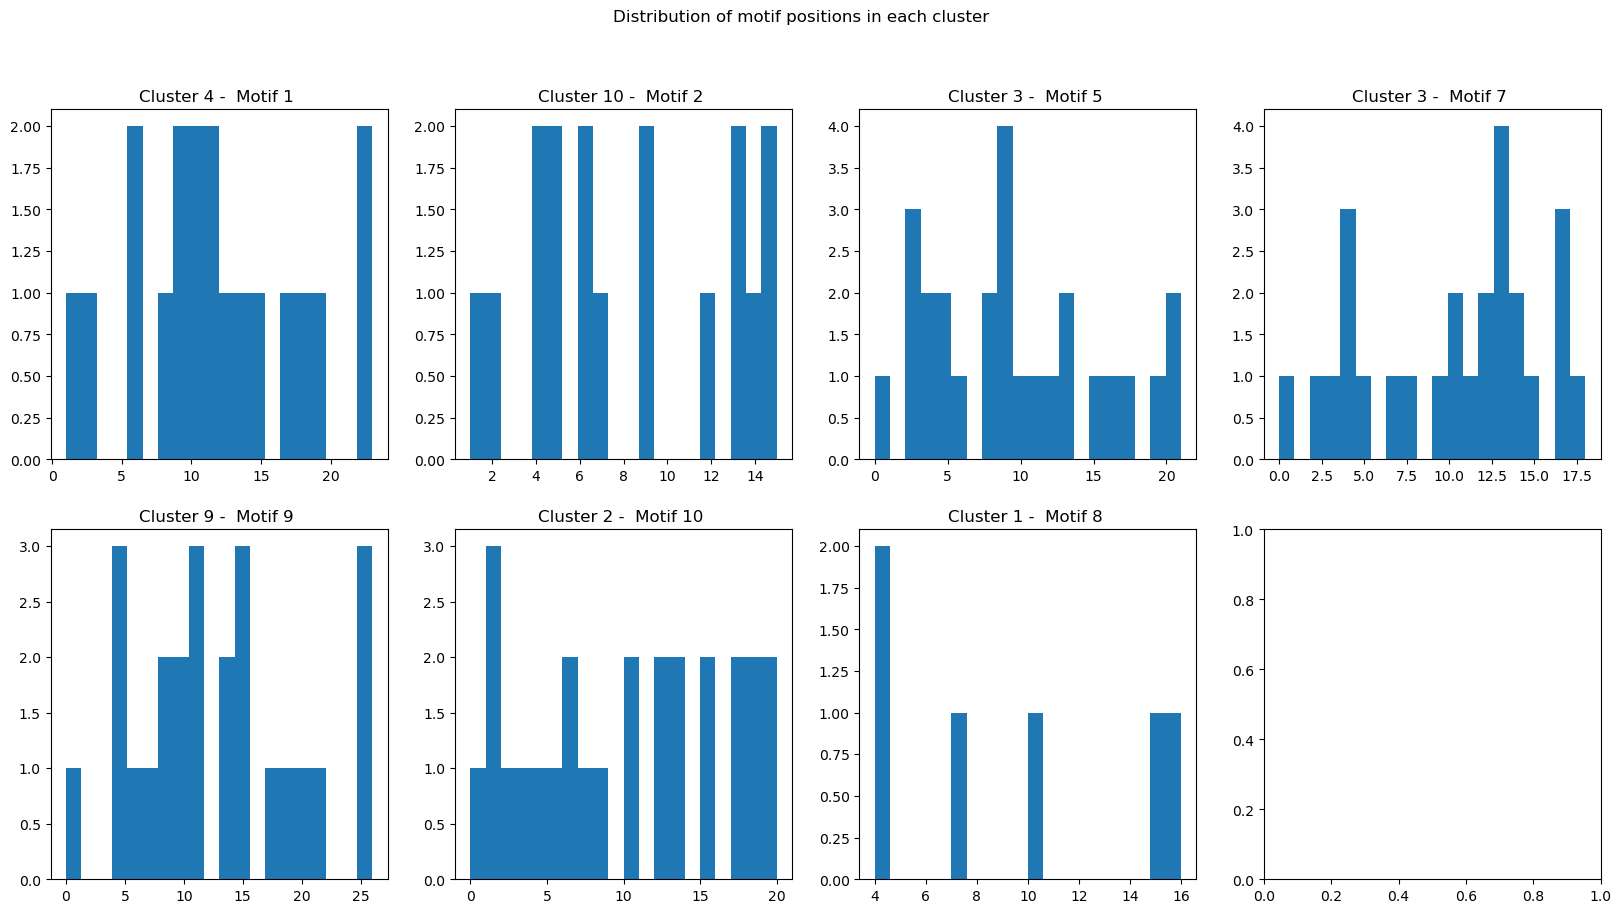

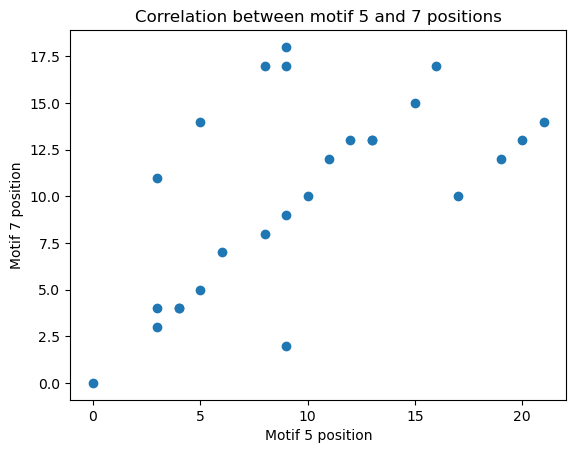

In [199]:
motif_positions = []
for motif_index in selected_motif_index:
    cluster_seq_index = train_seqs[train_seqs["cluster"] == motif_index_cluster_map[motif_index]].index
    motif_pos = scores_train[motif_index - 1].argmax(1)[cluster_seq_index]
    motif_positions.append(motif_pos)
# plot hist of motif positions
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i, pos in enumerate(motif_positions):
    ax[i//4, i%4].hist(pos, bins = 20)
    ax[i//4, i%4].set_title(f"Cluster {motif_index_cluster_map[selected_motif_index[i]]} -  Motif {selected_motif_index[i]} ")
# add super title
plt.suptitle("Distribution of motif positions in each cluster")
plt.show()
# correlation between motif positions for 5 and 7
motif5_pos = motif_positions[2]
motif7_pos = motif_positions[3]
plt.scatter(motif5_pos, motif7_pos)
plt.xlabel("Motif 5 position")
plt.ylabel("Motif 7 position")
plt.title("Correlation between motif 5 and 7 positions")
plt.show()



In [124]:
# For cluster 1, scan motif 1 across cluster 1 sequences and output index having max score
cluster1_seqs = train_seqs[train_seqs["cluster"] == 1]
cluster1_seqs = cluster1_seqs.sequence
cluster1_seqs = onehot_encode(cluster1_seqs)
cluster1_seqs.shape
cluster1_scores = scan_motif(cluster1_seqs, motifs[0])
max_score_index = np.argmax(cluster1_scores, axis = 1)
# get the sequence with max score
max_score_seq = cluster1_seqs.to_numpy()[np.arange(len(cluster1_seqs)), max_score_index]
# get the sequence with max score


ValueError: operands could not be broadcast together with shapes (26,54,4) (26,4) 

c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


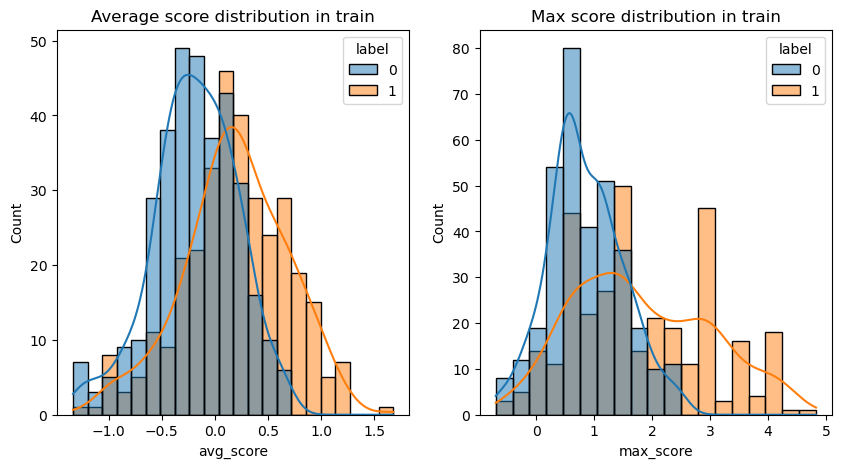

c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


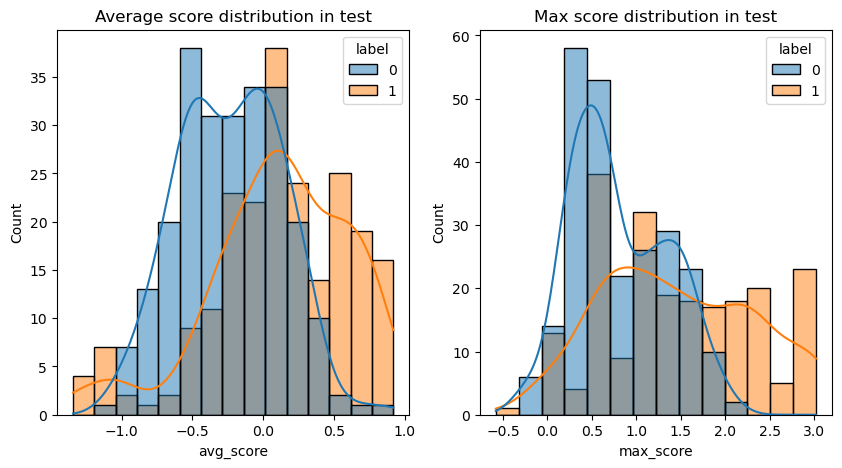

In [126]:
# histogram of average score and max score for train and test, labeled by class. Use subplot to plot them together
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.histplot(train_seqs, x = "avg_score", hue = "label", kde = True, ax = ax[0])
ax[0].set_title("Average score distribution in train")
sns.histplot(train_seqs, x = "max_score", hue = "label", kde = True, ax = ax[1])
ax[1].set_title("Max score distribution in train")
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.histplot(test_seqs, x = "avg_score", hue = "label", kde = True, ax = ax[0])
ax[0].set_title("Average score distribution in test")
sns.histplot(test_seqs, x = "max_score", hue = "label", kde = True, ax = ax[1])
ax[1].set_title("Max score distribution in test")
plt.show()


In [130]:
train_seqs

,sequence,label,motif_1,motif_2,motif_3,motif_4,motif_5,motif_6,avg_score,max_score,cluster
0,CAAGAACCAGGTCAGCCTGACCTGCCTGGTCAAAGGCTTCTATCCC...,1,3.503872,-0.584590,1.480646,-0.530527,0.114668,0.685797,0.778311,3.503872,1
1,CTATAGCACAGCACTGACCGTGACCAGCGTCCGGGGCCCATCTGGC...,1,-0.330377,1.822195,0.180308,0.538166,-0.558256,0.158257,0.301716,1.822195,10
2,CTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGGCCAACTCGTGG...,1,-0.329853,2.811341,-0.125825,0.745582,1.278580,-1.014505,0.560886,2.811341,11
3,GGGCCTGAGCTCGCCCGTCACAAAGAGCTTCAACAGGGGAGAGTGT...,1,0.590734,-0.312555,2.644681,-1.286850,-0.556442,-0.837870,0.040283,2.644681,4
4,CTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGG...,1,-0.244249,-0.605067,0.901422,-0.359328,-0.095380,0.697125,0.049087,0.901422,4
...,...,...,...,...,...,...,...,...,...,...,...
665,GTACATGGGATAGGTTCTCAACCCTCACCCCCCACCACGGGAGACT...,0,-0.135411,-0.729008,0.620314,-0.389594,-0.445720,-1.162087,-0.373584,0.620314,5
666,TCGGAATTGGGACCAAGGTCACCGTCCTGGGTCAGCCCAAGGCCAA...,0,0.658169,-0.050110,-0.434753,0.469831,-0.762863,-0.857014,-0.162790,0.658169,5
667,GTGAGCACCGTGCTGACCTCCAAATACCGTTCCTCCTGCCCGCTGG...,0,0.092312,-0.014204,0.029063,0.263847,-0.900278,0.174411,-0.059141,0.263847,3
668,TGACAATCTCTGGGCTCCAGGCTGAGGACGAGGCTGATTAGTACTG...,0,-0.614965,1.923929,1.785929,0.297682,0.568927,-0.129638,0.638644,1.923929,10


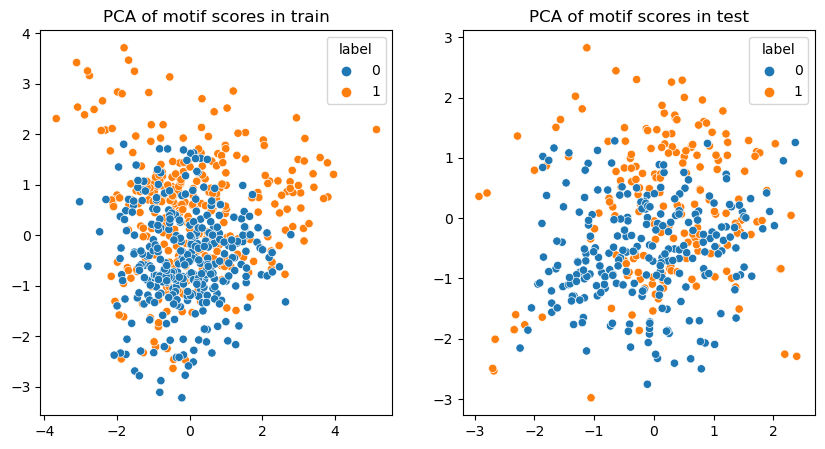

In [131]:
# PCA on motif scores
pca = PCA(n_components = 2)
pca_train = pca.fit_transform(train_seqs.iloc[:, 2:-3])
pca_test = pca.transform(test_seqs.iloc[:, 2:-2])

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(x = pca_train[:, 0], y = pca_train[:, 1], hue = train_seqs["label"], ax = ax[0])
ax[0].set_title("PCA of motif scores in train")
sns.scatterplot(x = pca_test[:, 0], y = pca_test[:, 1], hue = test_seqs["label"], ax = ax[1])
ax[1].set_title("PCA of motif scores in test")
plt.show()



In [332]:
logit.coef_

array([[ 0.51289941,  0.52419984,  0.01061481,  0.36122815,  0.22765635,
         0.        , -0.01209048, -0.03567166,  0.30620087,  0.44696927]])

In [229]:
selected_motif_index

[1, 2, 3, 10, 12, 15]

In [66]:
train_seqs.iloc[:, 2:-1]

,motif_1,motif_2,motif_3,motif_4,motif_5,motif_6,motif_7,motif_8,motif_9,motif_10
0,3.503872,-0.584590,1.480646,-0.327152,-0.128850,1.348830,0.058148,-0.503744,-0.557214,0.051702
1,-0.330377,1.822195,0.180308,0.307749,0.920063,1.626380,1.917237,0.279936,0.018215,0.451845
2,-0.329853,2.811341,-0.125825,-0.017100,-0.944458,0.295027,0.383393,-0.513478,0.568978,-0.730011
3,0.590734,-0.312555,2.644681,0.137709,-0.153015,0.043044,-1.024215,0.553367,-0.587973,-0.931168
4,-0.244249,-0.605067,0.901422,-0.984638,0.898245,1.313478,-0.682580,0.715890,-0.045100,-0.873763
...,...,...,...,...,...,...,...,...,...,...
665,-0.135411,-0.729008,0.620314,-0.241743,0.322026,-0.510117,-0.155496,-0.609741,-0.971759,-0.443230
666,0.658169,-0.050110,-0.434753,-0.936352,-0.388579,0.687861,1.885629,0.273596,0.164719,-0.330271
667,0.092312,-0.014204,0.029063,0.361487,0.308379,0.537133,0.227502,1.924451,-1.594025,1.104760
668,-0.614965,1.923929,1.785929,-0.470798,-1.534760,0.412342,0.223502,-0.187093,0.746939,-0.574601


In [202]:
train_seqs

,sequence,label,motif_1,motif_2,motif_3,motif_4,motif_5,motif_6,motif_7,motif_8,motif_9,motif_10,cluster
0,CAAGAACCAGGTCAGCCTGACCTGCCTGGTCAAAGGCTTCTATCCC...,1,3.503872,-0.584590,1.480646,-0.327152,-0.128850,1.348830,0.058148,-0.503744,-0.557214,0.051702,4
1,CTATAGCACAGCACTGACCGTGACCAGCGTCCGGGGCCCATCTGGC...,1,-0.330377,1.822195,0.180308,0.307749,0.920063,1.626380,1.917237,0.279936,0.018215,0.451845,8
2,CTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGGCCAACTCGTGG...,1,-0.329853,2.811341,-0.125825,-0.017100,-0.944458,0.295027,0.383393,-0.513478,0.568978,-0.730011,10
3,GGGCCTGAGCTCGCCCGTCACAAAGAGCTTCAACAGGGGAGAGTGT...,1,0.590734,-0.312555,2.644681,0.137709,-0.153015,0.043044,-1.024215,0.553367,-0.587973,-0.931168,5
4,CTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGG...,1,-0.244249,-0.605067,0.901422,-0.984638,0.898245,1.313478,-0.682580,0.715890,-0.045100,-0.873763,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,GTACATGGGATAGGTTCTCAACCCTCACCCCCCACCACGGGAGACT...,0,-0.135411,-0.729008,0.620314,-0.241743,0.322026,-0.510117,-0.155496,-0.609741,-0.971759,-0.443230,5
666,TCGGAATTGGGACCAAGGTCACCGTCCTGGGTCAGCCCAAGGCCAA...,0,0.658169,-0.050110,-0.434753,-0.936352,-0.388579,0.687861,1.885629,0.273596,0.164719,-0.330271,7
667,GTGAGCACCGTGCTGACCTCCAAATACCGTTCCTCCTGCCCGCTGG...,0,0.092312,-0.014204,0.029063,0.361487,0.308379,0.537133,0.227502,1.924451,-1.594025,1.104760,5
668,TGACAATCTCTGGGCTCCAGGCTGAGGACGAGGCTGATTAGTACTG...,0,-0.614965,1.923929,1.785929,-0.470798,-1.534760,0.412342,0.223502,-0.187093,0.746939,-0.574601,11


In [204]:
selected_motif_index = sorted(selected_motif_index)

In [230]:
train_seqs.iloc[:, 2:-1]

,motif_1,motif_2,motif_3,motif_4,motif_5,motif_6,motif_7,motif_8,motif_9,motif_10
0,-0.530527,0.114668,0.685797,0.337439,-0.195677,-0.105773,-0.405907,0.267301,2.164865,-0.506094
1,0.538166,-0.558256,0.158257,0.264083,0.644483,-0.209327,0.223806,-0.545038,-0.180032,0.672436
2,0.745582,1.278580,-1.014505,0.229524,3.520086,-0.186483,0.222024,-0.040570,-1.863296,-0.038132
3,-1.286850,-0.556442,-0.837870,0.563834,3.020961,-0.314062,-0.405907,-0.770182,1.024803,1.570970
4,-0.359328,-0.095380,0.697125,1.701910,-0.895829,0.443289,0.433265,1.051946,-0.239942,-1.636976
...,...,...,...,...,...,...,...,...,...,...
665,-0.389594,-0.445720,-1.162087,-0.625076,-0.493955,-0.453679,1.372365,0.126889,-0.238922,-0.084366
666,0.469831,-0.762863,-0.857014,0.118589,-0.563321,-0.231125,-0.666785,0.239750,-0.900006,-1.591082
667,0.263847,-0.900278,0.174411,1.245758,-1.801029,0.052273,0.170334,-0.378412,-0.120752,1.571751
668,0.297682,0.568927,-0.129638,-0.537199,0.341513,0.875930,0.326131,0.380302,1.802666,-0.318226


=======Train classifier using motif scores separately=======
Accuracy of logistic regression Train set: 0.78
Accuracy of logistic regression Test set: 0.72
Confusion matrix of logistic regression: 
[[189  54]
 [ 77 140]]


ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

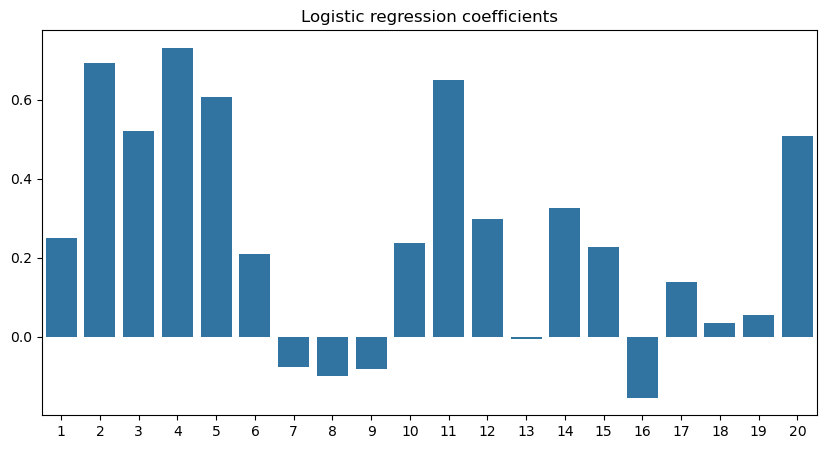

In [243]:
# train classifier using motifs score 1 to 10
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


print("=======Train classifier using motif scores separately=======")
X_train = train_seqs.iloc[:, 2:]
y_train = train_seqs["label"]
X_test = test_seqs.iloc[:, 2:]
y_test = test_seqs["label"]

# logistic regression
logit = LogisticRegression(max_iter = 1000, penalty="l1",  solver='liblinear')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
y_pred_train = logit.predict(X_train)
print(f"Accuracy of logistic regression Train set: {round(accuracy_score(y_train, y_pred_train), 2)}")
print(f"Accuracy of logistic regression Test set: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Confusion matrix of logistic regression: \n{confusion_matrix(y_test, y_pred)}")

# plot bar plot of coefficients
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.barplot(x = np.arange(1, 21), y = logit.coef_[0])
ax.set_title("Logistic regression coefficients")
ax.set_xticks(range(20), rotation = 45)
ax.set_xticklabels([f"motif_{i}" for i in range(1, 21)])
plt.show()


# heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = "gray", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix of logistic regression")
plt.show()


# Train using only selected motifs
print("=======Train classifier using selected motif scores=======")
X_train = train_seqs.iloc[:, 2:-1]
y_train = train_seqs["label"]
X_test = test_seqs.iloc[:, 2:]
y_test = test_seqs["label"]
X_train = X_train.iloc[:, np.array(selected_motif_index) - 1]
X_test = X_test.iloc[:, np.array(selected_motif_index) - 1]

# logistic regression
logit = LogisticRegression(max_iter = 1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
y_pred_train = logit.predict(X_train)
print(f"Accuracy of logistic regression Train set: {round(accuracy_score(y_train, y_pred_train), 2)}")
print(f"Accuracy of logistic regression Test set: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Confusion matrix of logistic regression: \n{confusion_matrix(y_test, y_pred)}")

# plot heat map of coefficients with annotation of motifs
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.heatmap(logit.coef_, annot = True, cmap = "gray")
ax.set_title("Logistic regression coefficients")
ax.set_xticks(range(7))
ax.set_xticklabels([f"motif_{i}" for i in selected_motif_index])
plt.show()

# heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = "viridis", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix of logistic regression")
plt.show()




# # train classifier using average score and max score
# print("=======Train classifier using average score and max score=======")
# X_train = train_seqs[["avg_score", "max_score"]]
# X_test = test_seqs[["avg_score", "max_score"]]
# # logistic regression
# logit = LogisticRegression(max_iter = 1000)
# logit.fit(X_train, y_train)
# y_pred = logit.predict(X_test)
# # accuracy on the train set
# y_pred_train = logit.predict(X_train)
# print(f"Accuracy of logistic regression Train set: {round(accuracy_score(y_train, y_pred_train), 2)}")
# #print accuracy in percentage keep 2 decimal places
# print(f"Accuracy of logistic regression: {round(accuracy_score(y_test, y_pred), 2)}")
# print(f"Confusion matrix of logistic regression: \n{confusion_matrix(y_test, y_pred)}")

# # train classifier using PCA of motif scores
# print("=======Train classifier using PCA of motif scores=======")
# X_train = pca_train
# X_test = pca_test
# # logistic regression
# logit = LogisticRegression(max_iter = 1000)
# logit.fit(X_train, y_train)
# y_pred = logit.predict(X_test)
# y_pred_train = logit.predict(X_train)
# print(f"Accuracy of logistic regression Train set: {round(accuracy_score(y_train, y_pred_train), 2)}")
# print(f"Accuracy of logistic regression: {round(accuracy_score(y_test, y_pred), 2)}")
# print(f"Confusion matrix of logistic regression: \n{confusion_matrix(y_test, y_pred)}")


In [244]:
import torch
import torch.nn as nn
import torch.optim as optim

In [285]:
class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dropout):
        super(ConvBlock1D, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x
    

class CNN1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                 num_classes, pe=False, dropout=0.2, pooling=1):
        super(CNN1D, self).__init__()
        #add embedding layer
        # self.embedding = nn.Embedding(in_channels, in_channels)
        # 3 Conv Blocks
        self.conv1 = ConvBlock1D(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = "same", dropout = dropout)
        self.conv2 = ConvBlock1D(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, stride= 1, padding = "same", dropout = dropout)
        self.conv3 = ConvBlock1D(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = "same", dropout = dropout)
        # global pooling
        self.pool = nn.AdaptiveAvgPool1d(pooling)
        self.classification_head = nn.Sequential(
            nn.Linear(out_channels*pooling, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, num_classes)
        )

    def l1_loss(self):
        l1 = 0
        for p in self.parameters():
            l1 += p.abs().sum()

        l1 = l1/len(list(self.parameters()))
        return l1
        
    def forward(self, x):
        # x = self.embedding(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.classification_head(x)
        return x

In [292]:
num_channels = 4
out_channels = 24
kernel_size = 11
num_classes = 2
model = CNN1D(in_channels=num_channels, out_channels = out_channels, kernel_size = kernel_size, \
            num_classes=num_classes, dropout = 0.2, pooling = 6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch 1/200, Train Loss: 0.698134580079247, Val Loss: 0.6893398046493531, Reg Loss: 0.004330618306994438
Epoch 2/200, Train Loss: 0.695789940216962, Val Loss: 0.6896665453910827, Reg Loss: 0.004327950533479452
Epoch 3/200, Train Loss: 0.6938154557171989, Val Loss: 0.689832603931427, Reg Loss: 0.00432542571797967
Epoch 4/200, Train Loss: 0.6928449448417214, Val Loss: 0.6893953084945679, Reg Loss: 0.004322976339608431
Epoch 5/200, Train Loss: 0.6910784665276023, Val Loss: 0.689364743232727, Reg Loss: 0.004320626612752676
Epoch 6/200, Train Loss: 0.691647098344915, Val Loss: 0.687384843826294, Reg Loss: 0.004318071994930506
Epoch 7/200, Train Loss: 0.6891339456333834, Val Loss: 0.686804187297821, Reg Loss: 0.0043153888545930386
Epoch 8/200, Train Loss: 0.685134067254908, Val Loss: 0.6871289134025573, Reg Loss: 0.004312905017286539
Epoch 9/200, Train Loss: 0.6833211253671085, Val Loss: 0.6848079085350036, Reg Loss: 0.00431041931733489
Epoch 10/200, Train Loss: 0.6815959145041073, Val Loss:

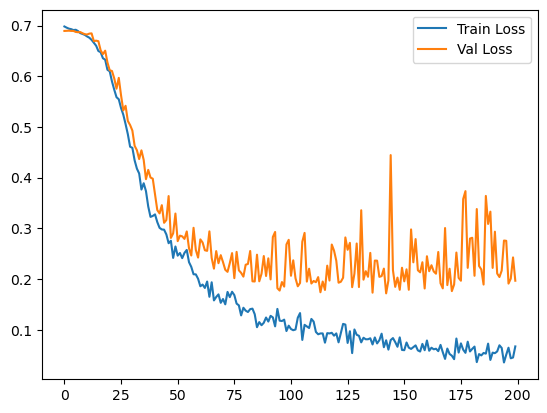

Accuracy of CNN model: 0.75
Confusion matrix of CNN model: 
[[199  44]
 [ 70 147]]


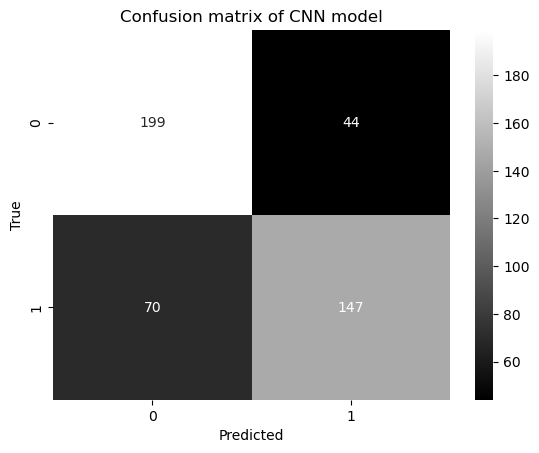

In [293]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(onehot_train, dtype = torch.float32).permute(0,2,1), torch.tensor(y_train.to_numpy(), dtype = torch.long))
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle = True)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, reg_coef = 0.00):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            reg_loss = model.l1_loss()
            loss += reg_coef*reg_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss/len(train_loader))
        model.eval()
        val_loss = 0
        for i, (x, y) in enumerate(val_loader):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Reg Loss: {reg_loss * reg_coef}")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, 200, 0.0001)

plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.legend()
plt.show()

# test the model

test_dataset = torch.utils.data.TensorDataset(torch.tensor(onehot_test, dtype = torch.float32).permute(0,2,1), torch.tensor(y_test.to_numpy(), dtype = torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

model.eval()
y_pred = []
y_true = []
for i, (x, y) in enumerate(test_loader):
    y_pred.extend(model(x).argmax(dim = 1).tolist())
    y_true.extend(y.tolist())
print(f"Accuracy of CNN model: {round(accuracy_score(y_true, y_pred), 2)}")

print(f"Confusion matrix of CNN model: \n{confusion_matrix(y_true, y_pred)}")

# plot heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, cmap = "gray", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix of CNN model")
plt.show()





In [278]:
# calculate  train accuracy 
model.eval()
y_pred_train = model(torch.tensor(onehot_train, dtype = torch.float32).permute(0,2,1)).argmax(dim = 1).tolist()
print(f"Accuracy of CNN model on train set: {round(accuracy_score(y_train.to_numpy(), y_pred_train), 2)}")


Accuracy of CNN model on train set: 0.99


In [294]:
import captum
from captum.attr import IntegratedGradients, TokenReferenceBase, visualization

# get the integrated gradients using captum
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(torch.FloatTensor(onehot_test).permute(0,2,1), target=1, return_convergence_delta=True)






In [183]:
# visualize the integrated gradients
visualization.visualize_text([test_seqs["sequence"][0]], attributions[0].detach().numpy(), 1)
plt.show()


TypeError: visualize_text() takes from 1 to 2 positional arguments but 3 were given

In [208]:
attributions_modisco.shape

(460, 54, 4)

In [244]:
attributions_modisco = attributions
#save as npz
np.save("ig_modisco.npy", attributions_modisco.detach().numpy())

In [240]:
attributions_modisco.shape

torch.Size([460, 4, 54])

In [275]:
indices = torch.where(attributions_modisco != 0)

In [294]:
dl = captum.attr.DeepLift(model)
attribution = dl.attribute(torch.FloatTensor(onehot_test).permute(0,2,1), target=1)

c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\khoah\anaconda3\envs\cs224n\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [297]:
attribution.shape
attributions_modisco = 

torch.Size([460, 4, 54])

In [299]:
attribution[0]

tensor([[-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.2500, -0.0000, -0.0000,
          0.2957, -0.0000, -0.0000,  0.2255,  0.0000, -0.0000,  0.3184,  0.0000,
         -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.2807,
          0.0000, -0.0000, -0.0000,  0.3870, -0.0000, -0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0297,  0.0000,
         -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0451,  0.0000,  0.1524, -0.0000,  0.0000, -0.0078],
        [-0.0000, -0.0000,  0.0280, -0.2457, -0.1931,  0.0000, -0.4589, -0.1879,
         -0.0000, -0.3634, -0.1160, -0.0000, -0.0000,  0.2251, -0.0000, -0.1462,
          0.1697,  0.0000, -0.0000,  0.0886, -0.2131,  0.0000,  0.2352,  0.0000,
          0.1836,  0.1919, -0.2840,  0.0000,  0.2013,  0.0000,  0.0000,  0.0434,
          0.0113,  0.0000, -0.0000, -0.1027,  0.0000,  0.0000, -0.0000,  0.0000,
          0.2548, -0.1723, -0.0000,  0.0000, 

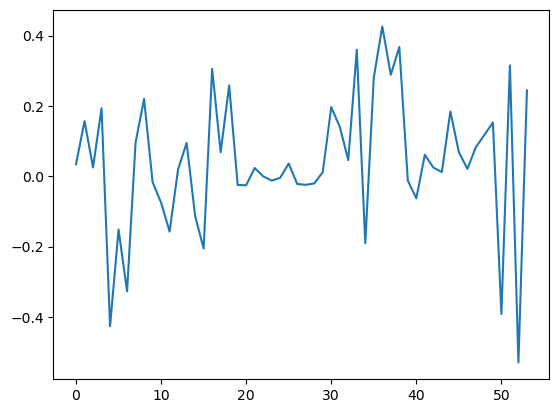

In [284]:
plt.plot(attributions_modisco[indices].reshape(460, 54)[10])

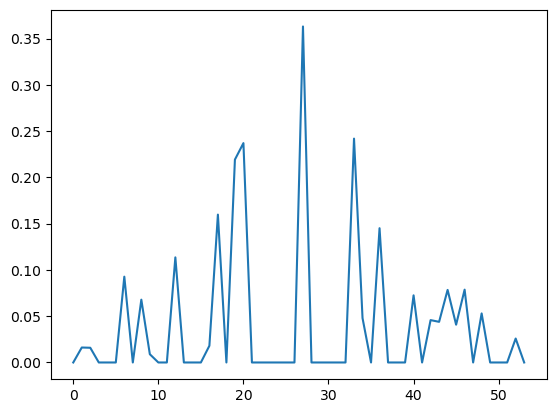

In [271]:
plt.plot(attributions_modisco.max(1)[0][300])

In [239]:
ohe_modisco.shape

(460, 4, 54)

In [245]:
ohe_modisco = torch.tensor(onehot_test).permute(0,2,1).detach().numpy()
np.save("ohe_modisco.npy", ohe_modisco)

In [302]:
# read h5 file
import h5py
f = h5py.File("modisco_results_12.h5", "r")
f.keys()



<KeysViewHDF5 ['pos_patterns']>

In [303]:
f["pos_patterns"]

<HDF5 group "/pos_patterns" (0 members)>